In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import soundfile as sf
import soxr
import scipy.signal
import functools
import multiprocessing

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_figures_cnn
import util_stimuli
import util_misc

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model


2024-01-09 22:54:57.614069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 22:54:59.428110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/foreground_swc/022_animals.wav'
y_src, sr_src = sf.read(fn)
sr = 20000
dur = 0.75
y = soxr.resample(y_src, sr_src, sr)
y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)

ipd.display(ipd.Audio(data=y, rate=sr))


In [3]:
kwargs_nervegram = {
    'nervegram_dur': None,
    'nervegram_fs': 10e3,
    'buffer_start_dur': 0.0,
    'buffer_end_dur': 0.0,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 100,
    'min_cf': 125,
    'max_cf': 10e3,
    'max_spikes_per_train': 1000,
    'num_spike_trains': 1,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3e3,
    'IhcLowPass_order': 7,
    'spont': 4.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'synapseMode': 0,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': False,
    'nervegram_spike_tensor_fs': 100e3,
}

list_dict_modification = [
    {'IhcLowPass_cutoff': 3e3},
    {'IhcLowPass_cutoff': 1e3},
    {'IhcLowPass_cutoff': 320},
    {'IhcLowPass_cutoff': 50},
]
def func_to_parallelize(dict_modification):
    np.random.seed(0)
    kwargs_nervegram_modified = dict(kwargs_nervegram)
    kwargs_nervegram_modified.update(dict_modification)
    return bez2018model.nervegram(y, sr, **kwargs_nervegram_modified)

with multiprocessing.Pool(len(list_dict_modification)) as p:
    list_out_dict = p.map(func_to_parallelize, list_dict_modification)

print(len(list_out_dict))


4


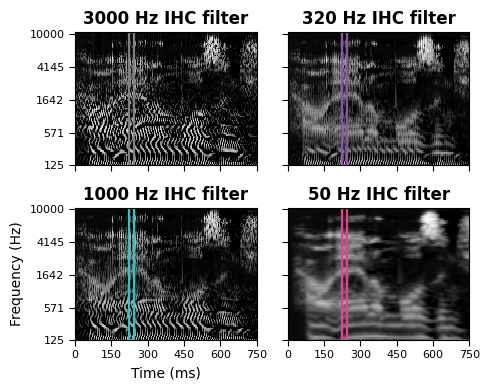

figures_src/schematic_phase_locking_manipulation_nervegram.pdf


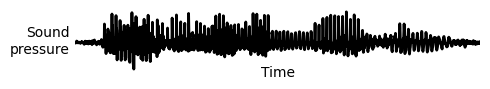

figures_src/schematic_phase_locking_manipulation_nervegram_waveform.pdf


In [12]:
map_condition_to_kwargs_plot = {
    3000: {'color': '#808088', 'alpha': 1.0, 'zorder': 1, 'label': '3000 Hz'},
    1000: {'color': '#28C8C8', 'alpha': 0.45, 'zorder': 2, 'label': '1000 Hz'},
    320: {'color': '#8856a7', 'alpha': 0.30, 'zorder': 3, 'label': '320 Hz'},
    50: {'color': '#F03C8C', 'alpha': 0.15, 'zorder': 4, 'label': '50 Hz'},
}

fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), sharex=True, sharey=True)
ax_arr = ax_arr.T.reshape([-1])
for itr, out_dict in enumerate(list_out_dict):
    ax = ax_arr[itr]
    nervegram = out_dict['nervegram_meanrates']
    waveform = out_dict['signal']
    sr_nervegram = out_dict['nervegram_fs']
    sr_waveform = out_dict['signal_fs']
    cfs = out_dict['cf_list']
    cutoff = out_dict['IhcLowPass_cutoff']
    tmin = 0.225
    tmax = tmin + 0.020
    str_title = '{} Hz IHC filter'.format(int(cutoff))
    color = map_condition_to_kwargs_plot[int(cutoff)]['color']
    ax = util_figures.make_nervegram_plot(
        ax,
        nervegram,
        sr=sr_nervegram,
        cfs=cfs,
        fontsize_labels=10,
        fontsize_title=12,
        fontsize_ticks=8,
        fontweight_labels=None,
        str_xlabel='Time (ms)' if itr == 1 else None,
        str_ylabel='Frequency (Hz)' if itr == 1 else None,
        str_title=str_title,
        fontweight_title='bold',
        nxticks=6,
        nyticks=5,
        interpolation='none')
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=1.5,
            edgecolor='w',
            facecolor='none'))
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=1.5,
            edgecolor=color,
            facecolor='none'))
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_phase_locking_manipulation_nervegram.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)

fig, ax = plt.subplots(figsize=(5, 1.))
t_waveform = np.arange(len(waveform)) / sr_waveform
DECIMATE = 10
ax.plot(t_waveform[DECIMATE//2::DECIMATE], waveform[DECIMATE//2::DECIMATE], color='k', lw=2)
ax = util_figures.format_axes(
    ax,
    xlimits=[t_waveform[0], t_waveform[-1]],
#     ylimits=[waveform.min(), waveform.max()],
    yticks=[],
    xticks=[],
    spines_to_hide=['top', 'bottom', 'right', 'left'],
)
ax.set_ylabel('Sound\npressure', rotation=0, ha='right', va='center', fontsize=10)
ax.set_xlabel('Time', rotation=0, labelpad=-5, fontsize=10)
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_phase_locking_manipulation_nervegram_waveform.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


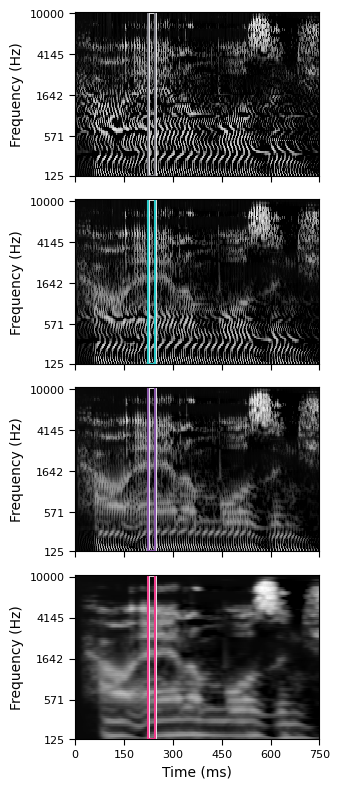

figures_poster/schematic_phase_locking_manipulation_nervegram.pdf


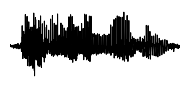

figures_poster/schematic_phase_locking_manipulation_nervegram_waveform.pdf


In [7]:
map_condition_to_kwargs_plot = {
    3000: {'color': '#808088', 'alpha': 1.0, 'zorder': 1, 'label': '3000 Hz'},
    1000: {'color': '#28C8C8', 'alpha': 0.45, 'zorder': 2, 'label': '1000 Hz'},
    320: {'color': '#8856a7', 'alpha': 0.30, 'zorder': 3, 'label': '320 Hz'},
    50: {'color': '#F03C8C', 'alpha': 0.15, 'zorder': 4, 'label': '50 Hz'},
}

fig, ax_arr = plt.subplots(nrows=4, ncols=1, figsize=(3.5, 8), sharex=True, sharey=True)
ax_arr = ax_arr.T.reshape([-1])
for itr, out_dict in enumerate(list_out_dict):
    ax = ax_arr[itr]
    nervegram = out_dict['nervegram_meanrates']
    waveform = out_dict['signal']
    sr_nervegram = out_dict['nervegram_fs']
    sr_waveform = out_dict['signal_fs']
    cfs = out_dict['cf_list']
    cutoff = out_dict['IhcLowPass_cutoff']
    tmin = 0.225
    tmax = tmin + 0.020
    str_title = '{} Hz IHC filter'.format(int(cutoff))
    color = map_condition_to_kwargs_plot[int(cutoff)]['color']
    ax = util_figures.make_nervegram_plot(
        ax,
        nervegram,
        sr=sr_nervegram,
        cfs=cfs,
        fontsize_labels=10,
        fontsize_title=12,
        fontsize_ticks=8,
        fontweight_labels=None,
        str_xlabel='Time (ms)' if itr == 3 else None,
        str_ylabel='Frequency (Hz)' if 1 == 1 else None,
#         str_title=str_title,
        fontweight_title='bold',
        nxticks=6,
        nyticks=5,
        interpolation='none')
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=2.0,
            edgecolor='w',
            facecolor='none'))
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (tmin * sr_nervegram, 0),
            (tmax - tmin) * sr_nervegram,
            nervegram.shape[0],
            lw=1.5,
            edgecolor=color,
            facecolor='none'))
plt.tight_layout()
plt.show()

fn_fig = 'figures_poster/schematic_phase_locking_manipulation_nervegram.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


fig, ax = plt.subplots(figsize=(2, 1))
t_waveform = np.arange(len(waveform)) / sr_waveform
DECIMATE = 10
ax.plot(t_waveform[DECIMATE//2::DECIMATE], waveform[DECIMATE//2::DECIMATE], color='k', lw=0.75)
ax = util_figures.format_axes(
    ax,
    xlimits=[t_waveform[0], t_waveform[-1]],
    yticks=[],
    xticks=[],
    spines_to_hide=['top', 'bottom', 'right', 'left'],
)
plt.tight_layout()
plt.show()

fn_fig = 'figures_poster/schematic_phase_locking_manipulation_nervegram_waveform.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


/tmp/ipykernel_23171/3127506507.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


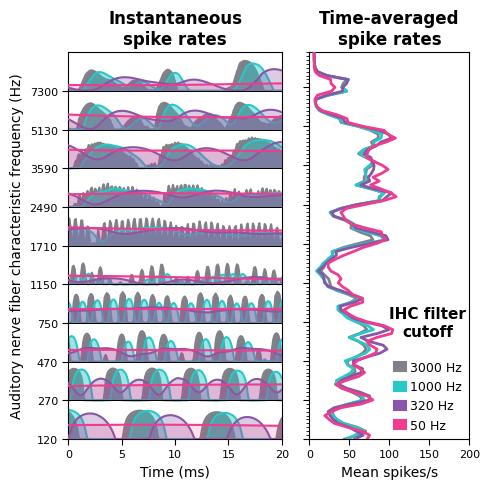

figures_src/schematic_phase_locking_manipulation.pdf


In [11]:
figsize = (5, 5)
fig, ax_arr = plt.subplots(
    figsize=figsize,
    nrows=1,
    ncols=2,
    gridspec_kw={'width_ratios': [2, 1.5]})

ax = ax_arr[0]
for dict_modification, out_dict_modified in zip(list_dict_modification, list_out_dict):
    cutoff = out_dict_modified['IhcLowPass_cutoff']
    nervegram = out_dict_modified['nervegram_meanrates']
    waveform = out_dict_modified['signal']
    sr_nervegram = out_dict_modified['nervegram_fs']
    sr_waveform = out_dict_modified['signal_fs']
    cfs = out_dict_modified['cf_list']
    t_waveform = np.arange(0, len(waveform)) / sr_waveform
    t_nervegram = np.arange(0, nervegram.shape[1]) / sr_nervegram
    TIDX = np.logical_and(t_waveform >= tmin, t_waveform <= tmax)
    ty = 1e3 * t_waveform[TIDX]
    ty = ty - ty[0]
    y = waveform[TIDX]
    TIDX = np.logical_and(t_nervegram >= tmin, t_nervegram <= tmax)
    tg = 1e3 * t_nervegram[TIDX]
    tg = tg - tg[0]
    g = nervegram[:, TIDX]
    list_ytick = []
    list_yticklabel = []
    count = 0
    offset = 200
    for itr_g in np.arange(0, g.shape[0], 10):
        baseline = offset * count
        yg = g[itr_g, :]
        color = map_condition_to_kwargs_plot[int(cutoff)]['color']
        alpha = map_condition_to_kwargs_plot[int(cutoff)]['alpha']
        zorder = map_condition_to_kwargs_plot[int(cutoff)]['zorder']
        ax.axhline(baseline, color='k', lw=0.5, zorder=10)
        ax.plot(tg, yg + baseline, color=color, lw=1.5, zorder=zorder)
        ax.fill_between(tg, g[itr_g, :] + baseline, baseline, color=color, lw=0, zorder=zorder, alpha=alpha)
        count += 1
        list_ytick.append(baseline)
        list_yticklabel.append(cfs[itr_g])
    yticks = list_ytick
    yticklabels = []
    for itr, val in enumerate(list_yticklabel):
        if 1:
            yticklabels.append(int(10 * np.round(val / 10)))
        else:
            yticklabels.append('')
ax = util_figures.format_axes(
    ax,
    xlimits=[tg[0], tg[-1]],
    ylimits=[0, baseline + max(offset, g[-1].max())],
    yticks=yticks,
    yticklabels=yticklabels,
    xticks=[0, 5, 10, 15, 20],
    fontsize_ticks=8,
    str_xlabel='Time (ms)',
    str_ylabel='Auditory nerve fiber characteristic frequency (Hz)',
    fontsize_labels=10,
    str_title='Instantaneous\nspike rates',
    fontweight_title='bold',
)
ax.set_facecolor('w')


ax = ax_arr[1]
for dict_modification, out_dict_modified in zip(list_dict_modification, list_out_dict):
    cutoff = out_dict_modified['IhcLowPass_cutoff']
    nervegram = out_dict_modified['nervegram_meanrates']
    waveform = out_dict_modified['signal']
    sr_nervegram = out_dict_modified['nervegram_fs']
    sr_waveform = out_dict_modified['signal_fs']
    cfs = out_dict_modified['cf_list']
    t_waveform = np.arange(0, len(waveform)) / sr_waveform
    t_nervegram = np.arange(0, nervegram.shape[1]) / sr_nervegram
    TIDX = np.logical_and(t_waveform >= tmin, t_waveform <= tmax)
    ty = 1e3 * t_waveform[TIDX]
    ty = ty - ty[0]
    TIDX = np.logical_and(t_nervegram >= tmin, t_nervegram <= tmax)
    g = nervegram[:, TIDX].mean(axis=1)
    yg = np.arange(len(g))
    color = map_condition_to_kwargs_plot[int(cutoff)]['color']
    zorder = map_condition_to_kwargs_plot[int(cutoff)]['zorder']
    label = map_condition_to_kwargs_plot[int(cutoff)]['label']
    ax.plot(g, yg, color=color, lw=2, zorder=zorder, label=label)
yticks = np.arange(0, g.shape[0], 10)
yticklabels = [int(10 * np.round(cfs[_] / 10)) for _ in yticks]
ax = util_figures.format_axes(
    ax,
    xlimits=[0, 200],
    ylimits=[yg[0], yg[-1]],
    yticks=yticks,
    yticks_minor=yg,
    yticklabels=[],
    xticks=[0, 50, 100, 150, 200],
    fontsize_ticks=8,
    fontsize_labels=10,
    str_xlabel='Mean spikes/s',
    str_title='Time-averaged\nspike rates',
    fontweight_title='bold',
)
ax.text(148, 34, 'IHC filter\ncutoff', ha='center', va='top', fontweight='bold', fontsize=11)
leg = ax.legend(
    frameon=False,
    framealpha=1,
    handletextpad=0.75,
    borderaxespad=0.2,
    handlelength=0.2,
    fontsize=9,
    ncol=1,
    columnspacing=0.75,
    loc='lower right',
    title_fontproperties={'size': 10, 'weight': 'bold'})
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
ax.set_facecolor('w')

fig.patch.set_color('none')

plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_phase_locking_manipulation.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
print(fn_fig)


/tmp/ipykernel_36383/3467761641.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


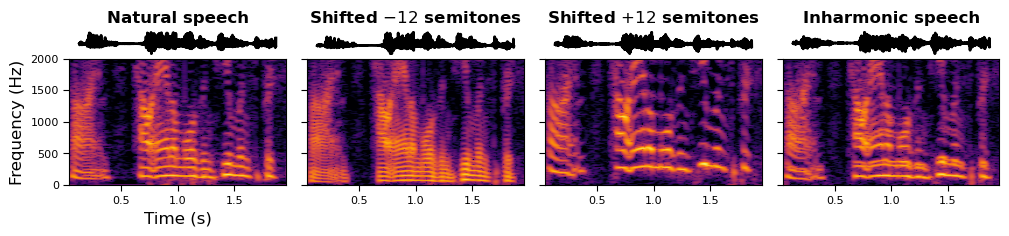

figures_src/schematic_spkr_word_pitch_altered_spectrograms.pdf


In [2]:
fn_template = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/{}/022_animals.wav'
list_fn = [
    fn_template.format(_) for _ in [
        'foreground_swc',
        'STRAIGHT/foreground_swc_shifted_f0_N12semitones',
        'STRAIGHT/foreground_swc_shifted_f0_P12semitones',
        'STRAIGHT/foreground_swc_inharmonic',
    ]
]
list_title = [
    'Natural speech',
    r'Shifted $-12$ semitones',
    r'Shifted $+12$ semitones',
    'Inharmonic speech',
]
gridspec_kw = {
    'hspace': 0.05,
    'wspace': 0.10,
    'height_ratios': [0.75, 4],
}
ncols = len(list_fn)
nrows = 2
fig, ax_arr = plt.subplots(
    figsize=(3 * ncols, 1. * nrows),
    nrows=nrows,
    ncols=ncols,
    gridspec_kw=gridspec_kw,
    sharey=False,
    sharex=False)
for c, fn in enumerate(list_fn):
    y_src, sr_src = sf.read(fn)
    sr = 20e3
    dur = 2.0
    y = soxr.resample(y_src, sr_src, sr)
    y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)
    t = np.arange(0, dur, 1/sr)
    nfft = 2 ** 11
    kwargs_specgram = {
        'NFFT': nfft,
        'Fs': sr,
        'mode': 'magnitude',
        'scale': 'dB',
        'cmap': 'inferno',
        'noverlap': int(0.9 * nfft),
        'clim': [-100, -30],
    }
    ax_arr[1, c].specgram(y, **kwargs_specgram)
    util_figures.format_axes(
        ax_arr[1, c],
        ylimits=[0, 2e3],
        xticks=[0.5, 1, 1.5],
        fontsize_ticks=8,
        yticklabels=None if c == 0 else [],
        str_xlabel='Time (s)' if c == 0 else None,
        str_ylabel='Frequency (Hz)' if c == 0 else None)
    DECIMATE = 10
    ax_arr[0, c].plot(t[DECIMATE//2::DECIMATE], y[DECIMATE//2::DECIMATE], color='k', lw=2)
    ax_arr[0, c] = util_figures.format_axes(
        ax_arr[0, c],
        str_title=list_title[c],
        fontweight_title='bold',
        xlimits=ax_arr[0, c].get_xlim(),
        yticks=[],
        xticks=[],
        spines_to_hide=['top', 'bottom', 'right', 'left'])
plt.tight_layout()
plt.show()

# fn_fig = 'figures_src/schematic_spkr_word_pitch_altered_spectrograms.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
# print(fn_fig)


/tmp/ipykernel_14579/878928335.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


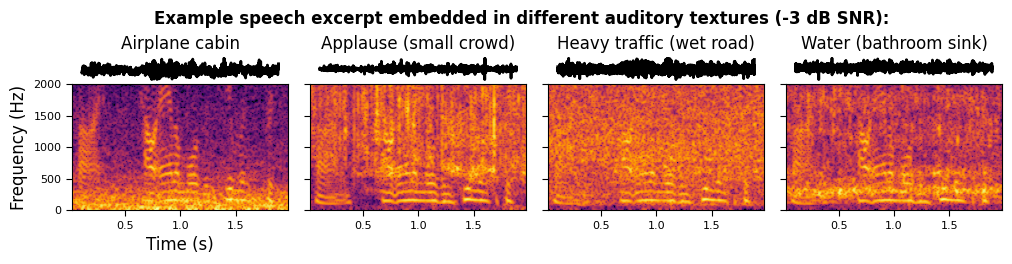

figures_src/schematic_spkr_word_synthetic_textures_spectrograms.pdf


In [3]:
sr = 20e3
dur = 2.0

fn_foreground = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/foreground_swc/022_animals.wav'
y_foreground, sr_src = sf.read(fn_foreground)
y_foreground = soxr.resample(y_foreground, sr_src, sr)
y_foreground = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y_foreground, int(dur * sr)), 60.0)

fn_template = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/synthetic_textures/{}/000.wav'
list_fn = [
    fn_template.format(_) for _ in [
        '002_airplane_yout',
        '005_applause_small_crowd',
        '017_heavy_traffic_wet_road',
        '038_water_bathroom_sink',
    ]
]
list_title = [
    'Airplane cabin',
    'Applause (small crowd)',
    'Heavy traffic (wet road)',
    'Water (bathroom sink)',
]
gridspec_kw = {
    'hspace': 0.05,
    'wspace': 0.10,
    'height_ratios': [0.75, 4],
}
ncols = len(list_fn)
nrows = 2
fig, ax_arr = plt.subplots(
    figsize=(3 * ncols, 1.15 * nrows),
    nrows=nrows,
    ncols=ncols,
    gridspec_kw=gridspec_kw,
    sharey=False,
    sharex=False)
for c, fn in enumerate(list_fn):
    y_src, sr_src = sf.read(fn)
    y = soxr.resample(y_src, sr_src, sr)
    y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)
    y = util_stimuli.combine_signal_and_noise(y_foreground, y, -3)
    t = np.arange(0, dur, 1/sr)
    nfft = 2 ** 10
    kwargs_specgram = {
        'NFFT': nfft,
        'Fs': sr,
        'mode': 'magnitude',
        'scale': 'dB',
        'cmap': 'inferno',
        'noverlap': int(0.9 * nfft),
        'clim': [-100, -30],
    }
    ax_arr[1, c].specgram(y, **kwargs_specgram)
    util_figures.format_axes(
        ax_arr[1, c],
        ylimits=[0, 2e3],
        xticks=[0.5, 1, 1.5],
        fontsize_ticks=8,
        yticklabels=None if c == 0 else [],
        str_xlabel='Time (s)' if c == 0 else None,
        str_ylabel='Frequency (Hz)' if c == 0 else None)
    DECIMATE = 10
    ax_arr[0, c].plot(t[DECIMATE//2::DECIMATE], y[DECIMATE//2::DECIMATE], color='k', lw=2)
    ax_arr[0, c] = util_figures.format_axes(
        ax_arr[0, c],
        str_title=list_title[c],
        # fontsize_title=10,
        # fontweight_title='bold',
        xlimits=ax_arr[0, c].get_xlim(),
        yticks=[],
        xticks=[],
        spines_to_hide=['top', 'bottom', 'right', 'left'])
plt.tight_layout()

fig.subplots_adjust(top=0.775)
fig.suptitle("Example speech excerpt embedded in different auditory textures (-3 dB SNR):", fontweight='bold')
plt.show()

fn_fig = 'figures_src/schematic_spkr_word_synthetic_textures_spectrograms.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


/cm/shared/openmind8/anaconda/3-2022.10/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7624: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)
/tmp/ipykernel_36383/3578771760.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


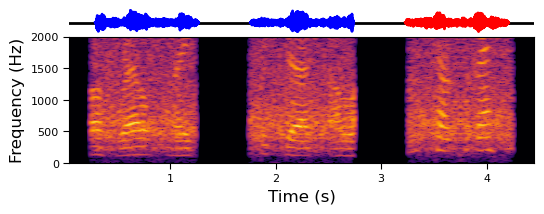

figures_src/schematic_spkr_discrimination_timit_ssn.pdf


In [3]:
list_fn = [
    '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_voice_discrimination/stim/timit_ssn/condition07/002.wav'
]
gridspec_kw = {
    'hspace': 0.05,
    'wspace': 0.10,
    'height_ratios': [0.75, 4],
}
ncols = len(list_fn)
nrows = 2
fig, ax_arr = plt.subplots(
    figsize=(6 * ncols, 1. * nrows),
    nrows=nrows,
    ncols=ncols,
    gridspec_kw=gridspec_kw,
    sharey=False,
    sharex=False)
ax_arr = ax_arr.reshape([nrows, ncols])
for c, fn in enumerate(list_fn):
    y_src, sr_src = sf.read(fn)
    sr = 20e3
    dur = 4.5
    y = soxr.resample(y_src, sr_src, sr)
    y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)
    t = np.arange(0, dur, 1/sr)
    nfft = 2 ** 11
    kwargs_specgram = {
        'NFFT': nfft,
        'Fs': sr,
        'mode': 'magnitude',
        'scale': 'dB',
        'cmap': 'inferno',
        'noverlap': int(0.9 * nfft),
        'clim': [-100, -30],
    }
    ax_arr[1, c].specgram(y, **kwargs_specgram)
    util_figures.format_axes(
        ax_arr[1, c],
        ylimits=[0, 2e3],
        xticks=np.arange(1, 5, 1),
        fontsize_ticks=8,
        yticklabels=None if c == 0 else [],
        str_xlabel='Time (s)' if c == 0 else None,
        str_ylabel='Frequency (Hz)' if c == 0 else None)
    ax_arr[0, c].plot(t[[0, -1]], y[[0, -1]], color='k', lw=2)
    TIDX = np.logical_and(t >= 0.25, t <= 1.25)
    ax_arr[0, c].plot(t[TIDX], y[TIDX], color='b', lw=2)
    TIDX = np.logical_and(t >= 1.75, t <= 2.75)
    ax_arr[0, c].plot(t[TIDX], y[TIDX], color='b', lw=2)
    TIDX = np.logical_and(t >= 3.25, t <= 4.25)
    ax_arr[0, c].plot(t[TIDX], y[TIDX], color='r', lw=2)
    ax_arr[0, c] = util_figures.format_axes(
        ax_arr[0, c],
        xlimits=[t[0], t[-1]],
        yticks=[],
        xticks=[],
        spines_to_hide=['top', 'bottom', 'right', 'left'])
plt.tight_layout()
plt.show()

# fn_fig = 'figures_src/schematic_spkr_discrimination_timit_ssn.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
# print(fn_fig)
